In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
# Load stock data
company = "BTC-USD"
start = dt.date(2015, 1, 1)
end = dt.date.today()

data = web.DataReader(company, "yahoo", start, end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999
...,...,...,...,...,...,...
2022-03-28,48086.835938,46690.203125,46821.851562,47128.003906,36362175703,47128.003906
2022-03-29,48022.289062,47100.437500,47100.437500,47465.730469,31397059069,47465.730469
2022-03-30,47655.148438,46746.210938,47456.898438,47062.664062,29333883962,47062.664062


In [3]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

prediction_days = 60
future_day = 30

X_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    X_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [4]:
# Build the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # prevent overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of the next closing value

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=25, batch_size=32)

# model.save()

2022-04-01 14:30:13.503716: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25
80/80 [==============================] - 4s 34ms/step - loss: 0.0126
Epoch 2/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0063
Epoch 3/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0061
Epoch 4/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0055
Epoch 5/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0051
Epoch 6/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0041
Epoch 7/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0039
Epoch 8/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0038
Epoch 9/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0037
Epoch 10/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0036
Epoch 11/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0034
Epoch 12/25
80/80 [==============================] - 3s 36ms/step - loss: 0.0034
Epoch 13/25
80/80 [==================

In [5]:
# Test the model accuracy on existing data
# Load Test Data
test_start = dt.date(2020, 1, 1) + dt.timedelta(days=-prediction_days)
test_end = dt.date.today()

test_data = web.DataReader(company, "yahoo", test_start, test_end)
actual_prices = test_data["Close"].values

total_dataset = pd.concat((data["Close"], test_data["Close"]), axis=0)

model_inputs = total_dataset[
    len(total_dataset) - len(test_data) - prediction_days :
].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


In [6]:
# Make Predictions on Test Data
X_test = []

for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x - prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


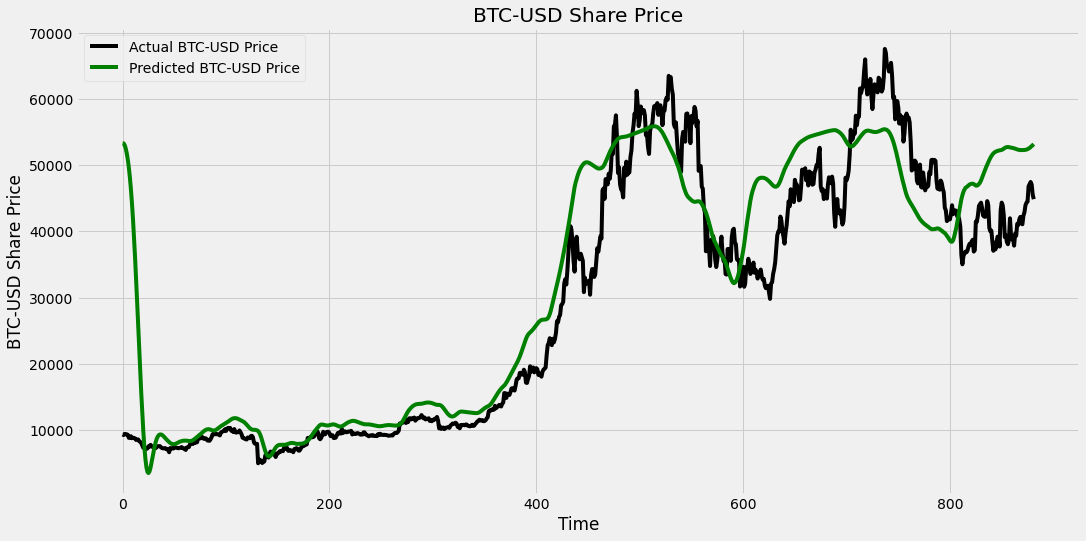

In [7]:
# Plot the test predictions
plt.figure(figsize=(16,8))
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend(loc='upper left')
plt.show()
# plt.savefig(f"./plot/{company}_LSTM_predicted.png")

In [8]:
# Predict Next Day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data
# real_data = np.array(real_data)
# real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
# print(scaler.inverse_transform(real_data[-1]))

# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print(f"Prediction: {prediction}")

[array([0.54571267, 0.54870453, 0.61320009, 0.61231402, 0.62672696,
        0.64791524, 0.65204294, 0.6553128 , 0.64383189, 0.62666024,
        0.62423448, 0.62353773, 0.62931618, 0.65882089, 0.64971932,
        0.59891189, 0.59138785, 0.5927409 , 0.56765098, 0.54752747,
        0.56549407, 0.55081124, 0.56618531, 0.57926776, 0.57764923,
        0.55694305, 0.63831348, 0.65554785, 0.64915925, 0.62731096,
        0.57813087, 0.58203331, 0.56748189, 0.56217024, 0.57219018,
        0.62035337, 0.58258051, 0.57304645, 0.57466451, 0.55901875,
        0.58598305, 0.58111623, 0.60790327, 0.60504596, 0.61765604,
        0.62343588, 0.60944499, 0.60692487, 0.6259312 , 0.63385758,
        0.64970558, 0.6554602 , 0.65771722, 0.69213936, 0.69670261,
        0.70171423, 0.69573302, 0.67311813, 0.66321262])]

In [9]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2648.000000,2648.000000,2648.000000,2648.000000,2.648000e+03,2648.000000
mean,12538.093775,11855.229195,12212.170722,12227.223303,1.548347e+10,12227.223303
std,16997.547731,16056.793035,16557.776876,16564.244101,2.011092e+10,16564.244101
min,211.731003,171.509995,176.897003,178.102997,7.860650e+06,178.102997
25%,706.768494,682.660492,700.133484,701.641006,1.070010e+08,701.641006
50%,6692.399902,6460.925049,6588.630127,6586.919922,5.904242e+09,6586.919922
75%,11400.711914,10780.723145,11047.612061,11066.993408,2.592067e+10,11066.993408
max,68789.625000,66382.062500,67549.734375,67566.828125,3.509679e+11,67566.828125
